In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4518756821642117347
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2031616
locality {
  bus_id: 1
}
incarnation: 4022384235373699903
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [8]:
"""
Build RBG Graph
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'

#FLAGS = tf.flags.FLAGS

#tf.flags.DEFINE_string('eval_type', 'joint', 'rgb, flow, or joint')
#tf.flags.DEFINE_boolean('imagenet_pretrained', True, '')
tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.INFO)
#eval_type = FLAGS.eval_type
#imagenet_pretrained = FLAGS.imagenet_pretrained
kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]
rgb_input = tf.placeholder(tf.float32, shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(_NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(rgb_input, is_training=False, dropout_keep_prob=1.0)
rgb_variable_map = {}
for variable in tf.global_variables():
    if variable.name.split('/')[0] == 'RGB':
        rgb_variable_map[variable.name.replace(':0', '')] = variable
rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)
model_logits = rgb_logits
model_predictions = tf.nn.softmax(model_logits)


In [9]:
"""
Run sample prediction with RBG only
"""
eval_type = 'rgb'
imagenet_pretrained = True
print("wiener")
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                print("pretrained")
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)
        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

wiener
pretrained
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
Norm of logits: 87.108879

Top classes and probabilities
0.99999666 25.856651 playing cricket
1.335341e-06 12.330331 playing kickball
4.5531024e-07 11.254368 catching or throwing baseball
3.14341e-07 10.883867 shooting goal (soccer)
1.9243211e-07 10.393132 catching or throwing softball
1.3096448e-07 10.008315 throwing discus
1.0681766e-07 9.804511 javelin throw
9.446406e-08 9.681608 golf putting
7.8428855e-08 9.495581 jogging
7.801721e-08 9.490317 hitting baseball
6.608454e-08 9.324324 triple jump
3.487828e-08 8.685253 hurling (sport)
2.996551e-08 8.533437 skateboarding
2.1083729e-08 8.1818905 hurdling
2.007925e-08 8.133076 playing tennis
1.8453855e-08 8.048662 breakdancing
1.7050727e-08 7.9695816 hammer throw
1.7004478e-08 7.9668646 shot put
1.4611323e-08 7

In [15]:
from scipy.ndimage.filters import gaussian_filter1d
def blur_image(X, sigma=1):
    start = time.time()
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    print("Blur time", time.time()-start)
    return X

In [24]:
def create_class_visualization(sess, target_y, logits, rgb_input, num_frames, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.
    
    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 4)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    X = np.random.rand(num_frames, 224, 224, 3)
    X = X[None]
    #X = preprocess_image(X)[None]
    
    ########################################################################
    # TODO: Compute the loss and the gradient of the loss with respect to  #
    # the input image, model.image. We compute these outside the loop so   #
    # that we don't have to recompute the gradient graph at each iteration #
    #                                                                      #
    # Note: loss and grad should be TensorFlow Tensors, not numpy arrays!  #
    #                                                                      #
    # The loss is the score for the target label, target_y. You should     #
    # use model.classifier to get the scores, and tf.gradients to compute  #
    # gradients. Don't forget the (subtracted) L2 regularization term!     #
    ########################################################################
    # logits command
    # loss = model.classifier[0, target_y] # scalar loss
    loss = logits[0, target_y] # scalar loss
    
    # model.image is just input data 
    # self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
    # grad = tf.gradients(loss, model.image) # gradient of loss with respect to model.image, same size as model.image
    # grad = tf.squeeze(grad) - l2_reg*2*model.image
    
    grad = tf.gradients(loss, rgb_input)
    grad = tf.squeeze(grad) - l2_reg*2*rgb_input
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        ########################################################################
        # TODO: Use sess to compute the value of the gradient of the score for #
        # class target_y with respect to the pixels of the image, and make a   #
        # gradient step on the image using the learning rate. You should use   #
        # the grad variable you defined above.                                 #
        #                                                                      #
        # Be very careful about the signs of elements in your code.            #
        ########################################################################
        # we want logits for loss, model.classifier are just logits
        # loss = model.classifier[0, target_y] # scalar loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        # gradient_step = sess.run(grad, feed_dict={model.image:X})
        gradient_step = sess.run(grad, feed_dict={rgb_input:X})
        X += learning_rate * gradient_step
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        #X = np.clip(X, -SQUEEZENET_MEAN/SQUEEZENET_STD, (1.0 - SQUEEZENET_MEAN)/SQUEEZENET_STD)
        if t % blur_every == 0:
            X = blur_image(X, sigma=1)
        print("iteration:", t, time.time()-start_time)
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            #plt.imshow(deprocess_image(X[0]))
            plt.imshow(X[0][0])
            
            if t == num_iterations-1:
                name = "experimental_vis/arm_wrestle{}.png"
                filenames = []
                for i in range(0, num_frames):
                    plt.imshow(X[0][i])
                    filename = name.format(i)
                    filenames.append(filename)
                    plt.savefig(name.format(i))
                    plt.show()
                images = []
                for filename in filenames:
                    images.append(imageio.imread(filename))
                    imageio.mimsave('experimental_vis/arm_wrestle.gif', images)
                    
            #class_name = class_names[target_y]
            
            class_name = "temp"
            plt.title('%s\nIteration %d / %d' % (class_name, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

Tensor("RGB/inception_i3d/Mean:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'num_iterations': 800, 'learning_rate': 1.5, 'max_jitter': 32, 'blur_every': 2}
Blur time 0.0830690860748
iteration: 0 1.47332811356


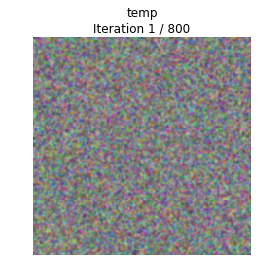

iteration: 1 2.69851613045
Blur time 0.0800290107727
iteration: 2 3.90553712845
iteration: 3 5.01456594467
Blur time 0.0835158824921
iteration: 4 6.21587109566
iteration: 5 7.31104707718
Blur time 0.0756728649139
iteration: 6 8.52071809769
iteration: 7 9.6145169735
Blur time 0.0473310947418
iteration: 8 10.76303792
iteration: 9 11.8238761425
Blur time 0.0471930503845
iteration: 10 13.0350410938
iteration: 11 14.1053431034
Blur time 0.0840289592743
iteration: 12 15.3396019936
iteration: 13 16.4561219215
Blur time 0.0690140724182
iteration: 14 17.6591761112
iteration: 15 18.7606101036
Blur time 0.0820457935333
iteration: 16 19.9668769836
iteration: 17 21.0653760433
Blur time 0.0641438961029
iteration: 18 22.1986570358
iteration: 19 23.2985339165
Blur time 0.0445690155029
iteration: 20 24.3805730343
iteration: 21 25.4280951023
Blur time 0.0850148200989
iteration: 22 26.5736730099
iteration: 23 27.6825680733
Blur time 0.0619509220123
iteration: 24 28.8034219742


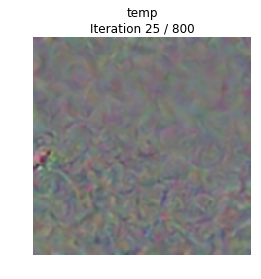

iteration: 25 30.0098659992
Blur time 0.0702121257782
iteration: 26 31.246598959
iteration: 27 32.3532960415
Blur time 0.0818178653717
iteration: 28 33.563822031
iteration: 29 34.6730430126
Blur time 0.0631880760193
iteration: 30 35.7947580814
iteration: 31 36.8974950314
Blur time 0.0858080387115
iteration: 32 38.1245820522
iteration: 33 39.2489550114
Blur time 0.0453248023987
iteration: 34 40.403646946
iteration: 35 41.4604411125
Blur time 0.0828721523285
iteration: 36 42.6799631119
iteration: 37 43.7898161411
Blur time 0.0833179950714
iteration: 38 45.0131509304
iteration: 39 46.175246954
Blur time 0.0694031715393
iteration: 40 47.3706459999
iteration: 41 48.4719851017
Blur time 0.0920050144196
iteration: 42 49.696408987
iteration: 43 50.8283650875
Blur time 0.0836360454559
iteration: 44 52.0558550358
iteration: 45 53.1718029976
Blur time 0.0691239833832
iteration: 46 54.3537819386
iteration: 47 55.459774971
Blur time 0.0841200351715
iteration: 48 56.6786689758
iteration: 49 57.81013

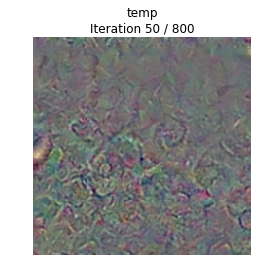

Blur time 0.0866370201111
iteration: 50 59.1482899189
iteration: 51 60.2797241211
Blur time 0.0850100517273
iteration: 52 61.465542078
iteration: 53 62.5740599632
Blur time 0.0830330848694
iteration: 54 63.7574589252
iteration: 55 64.887912035
Blur time 0.081148147583
iteration: 56 66.1023631096
iteration: 57 67.2119250298
Blur time 0.0862219333649
iteration: 58 68.4086821079
iteration: 59 69.5378909111
Blur time 0.0811548233032
iteration: 60 70.7488770485
iteration: 61 71.8721210957
Blur time 0.0854868888855
iteration: 62 73.0993289948
iteration: 63 74.2273409367
Blur time 0.0828111171722
iteration: 64 75.4359209538
iteration: 65 76.553497076
Blur time 0.0704598426819
iteration: 66 77.7551939487
iteration: 67 78.8544239998
Blur time 0.0444309711456
iteration: 68 79.9537479877
iteration: 69 81.0079400539
Blur time 0.0836100578308
iteration: 70 82.2358081341
iteration: 71 83.3522729874
Blur time 0.0473940372467
iteration: 72 84.4959321022
iteration: 73 85.5622959137
Blur time 0.04766106

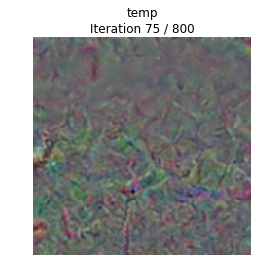

iteration: 75 87.8499839306
Blur time 0.0611078739166
iteration: 76 88.9604809284
iteration: 77 90.0287921429
Blur time 0.0852479934692
iteration: 78 91.1823029518
iteration: 79 92.2906501293
Blur time 0.0483810901642
iteration: 80 93.4047579765
iteration: 81 94.4909369946
Blur time 0.0471589565277
iteration: 82 95.6625380516
iteration: 83 96.7359220982
Blur time 0.0780649185181
iteration: 84 97.9461929798
iteration: 85 99.0643880367
Blur time 0.0816490650177
iteration: 86 100.295444012
iteration: 87 101.433254957
Blur time 0.08464884758
iteration: 88 102.651870966
iteration: 89 103.767414093
Blur time 0.0857939720154
iteration: 90 104.994909048
iteration: 91 106.114076138
Blur time 0.0716078281403
iteration: 92 107.331424952
iteration: 93 108.441712141
Blur time 0.0472149848938
iteration: 94 109.613834143
iteration: 95 110.68798995
Blur time 0.0842461585999
iteration: 96 111.913625002
iteration: 97 113.030157089
Blur time 0.116745948792
iteration: 98 114.292283058
iteration: 99 115.41

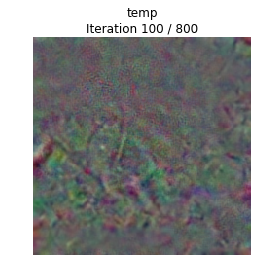

Blur time 0.0826740264893
iteration: 100 116.813548088
iteration: 101 117.933470964
Blur time 0.0482361316681
iteration: 102 119.121829987
iteration: 103 120.206258059
Blur time 0.0837459564209
iteration: 104 121.431548119
iteration: 105 122.55983901
Blur time 0.0855870246887
iteration: 106 123.79271102
iteration: 107 124.925372124
Blur time 0.0828750133514
iteration: 108 126.144263029
iteration: 109 127.270173073
Blur time 0.086208820343
iteration: 110 128.490139961
iteration: 111 129.606040001
Blur time 0.0876779556274
iteration: 112 130.822191
iteration: 113 131.949914932
Blur time 0.0856900215149
iteration: 114 133.183872938
iteration: 115 134.317405939
Blur time 0.084666967392
iteration: 116 135.543414116
iteration: 117 136.664011002
Blur time 0.0662968158722
iteration: 118 137.857710123
iteration: 119 138.968980074
Blur time 0.0636670589447
iteration: 120 140.101530075
iteration: 121 141.196705103
Blur time 0.0453431606293
iteration: 122 142.327867031
iteration: 123 143.388953924

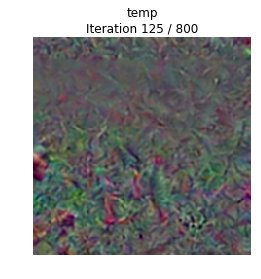

iteration: 125 145.803354025
Blur time 0.084568977356
iteration: 126 147.03034997
iteration: 127 148.1469841
Blur time 0.0542719364166
iteration: 128 149.286633015
iteration: 129 150.356538057
Blur time 0.0503251552582
iteration: 130 151.49123311
iteration: 131 152.580189943
Blur time 0.0476880073547
iteration: 132 153.767205954
iteration: 133 154.83000803
Blur time 0.069167137146
iteration: 134 156.037495136
iteration: 135 157.145540953
Blur time 0.0809531211853
iteration: 136 158.365853071
iteration: 137 159.486618042
Blur time 0.086562871933
iteration: 138 160.688946009
iteration: 139 161.808408022
Blur time 0.0853021144867
iteration: 140 163.02836895
iteration: 141 164.15341711
Blur time 0.0719499588013
iteration: 142 165.355232
iteration: 143 166.471275091
Blur time 0.0849230289459
iteration: 144 167.700909138
iteration: 145 168.825598001
Blur time 0.0856001377106
iteration: 146 170.039175034
iteration: 147 171.188378096
Blur time 0.0768220424652
iteration: 148 172.408738136
itera

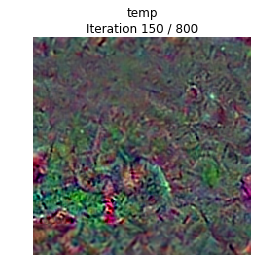

Blur time 0.0790390968323
iteration: 150 174.894648075
iteration: 151 176.064538002
Blur time 0.0455009937286
iteration: 152 177.181019068
iteration: 153 178.260602951
Blur time 0.0628809928894
iteration: 154 179.418913126
iteration: 155 180.515108109
Blur time 0.0657618045807
iteration: 156 181.66801405
iteration: 157 182.797626972
Blur time 0.0439419746399
iteration: 158 183.890139103
iteration: 159 184.938681126
Blur time 0.0606038570404
iteration: 160 186.044543028
iteration: 161 187.125118017
Blur time 0.0474729537964
iteration: 162 188.259901047
iteration: 163 189.321228981
Blur time 0.0704250335693
iteration: 164 190.498939037
iteration: 165 191.605899096
Blur time 0.0686149597168
iteration: 166 192.809982061
iteration: 167 193.914398909
Blur time 0.0692300796509
iteration: 168 195.093671083
iteration: 169 196.191915989
Blur time 0.062509059906
iteration: 170 197.310970068
iteration: 171 198.400650978
Blur time 0.065062046051
iteration: 172 199.517030001
iteration: 173 200.62078

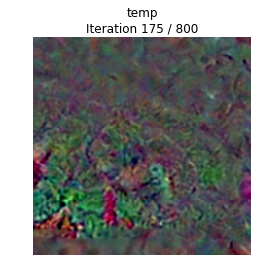

iteration: 175 202.968430042
Blur time 0.0710861682892
iteration: 176 204.138097048
iteration: 177 205.243237019
Blur time 0.0492701530457
iteration: 178 206.403809071
iteration: 179 207.472409964
Blur time 0.0629081726074
iteration: 180 208.581013918
iteration: 181 209.681046009
Blur time 0.0709829330444
iteration: 182 210.889678001
iteration: 183 211.991943121
Blur time 0.0453779697418
iteration: 184 213.087659121
iteration: 185 214.145584106
Blur time 0.0533349514008
iteration: 186 215.250684023
iteration: 187 216.333585024
Blur time 0.045135974884
iteration: 188 217.421523094
iteration: 189 218.473782063
Blur time 0.0449929237366
iteration: 190 219.574692965
iteration: 191 220.635462046
Blur time 0.0848770141602
iteration: 192 221.830676079
iteration: 193 222.941410065
Blur time 0.0668749809265
iteration: 194 224.092746019
iteration: 195 225.223292112
Blur time 0.047523021698
iteration: 196 226.438794136
iteration: 197 227.527189016
Blur time 0.0617580413818
iteration: 198 228.7136

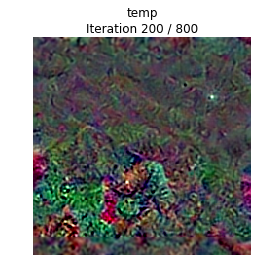

Blur time 0.0843679904938
iteration: 200 231.121788979
iteration: 201 232.261269093
Blur time 0.0695450305939
iteration: 202 233.501131058
iteration: 203 234.600743055
Blur time 0.0457139015198
iteration: 204 235.749161005
iteration: 205 236.799351931
Blur time 0.0453169345856
iteration: 206 237.883381128
iteration: 207 238.93718195
Blur time 0.0605530738831
iteration: 208 240.048706055
iteration: 209 241.113022089
Blur time 0.06192278862
iteration: 210 242.282680988
iteration: 211 243.385746002
Blur time 0.0472860336304
iteration: 212 244.530228138
iteration: 213 245.627769947
Blur time 0.0450630187988
iteration: 214 246.836291075
iteration: 215 247.910006046
Blur time 0.0608699321747
iteration: 216 249.045066118
iteration: 217 250.168771982
Blur time 0.0830011367798
iteration: 218 251.321066141
iteration: 219 252.45420599
Blur time 0.0477030277252
iteration: 220 253.644707918
iteration: 221 254.7223351
Blur time 0.0474951267242
iteration: 222 255.857025146
iteration: 223 256.92406392

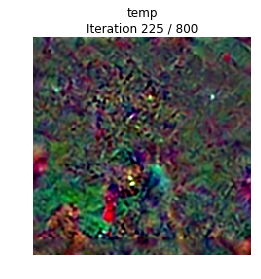

iteration: 225 259.23060298
Blur time 0.0473630428314
iteration: 226 260.390746117
iteration: 227 261.449937105
Blur time 0.0457298755646
iteration: 228 262.568490982
iteration: 229 263.634099007
Blur time 0.047679901123
iteration: 230 264.799267054
iteration: 231 265.864958048
Blur time 0.0462548732758
iteration: 232 266.965603113
iteration: 233 268.016309023
Blur time 0.0465140342712
iteration: 234 269.106543064
iteration: 235 270.163470984
Blur time 0.0455360412598
iteration: 236 271.260141134
iteration: 237 272.326808929
Blur time 0.0597360134125
iteration: 238 273.476202011
iteration: 239 274.561475992
Blur time 0.0779700279236
iteration: 240 275.735139132
iteration: 241 276.849705935
Blur time 0.0470168590546
iteration: 242 277.995372057
iteration: 243 279.062824965
Blur time 0.0712249279022
iteration: 244 280.228281975
iteration: 245 281.335405111
Blur time 0.0461580753326
iteration: 246 282.494220018
iteration: 247 283.556242943
Blur time 0.0856230258942
iteration: 248 284.7485

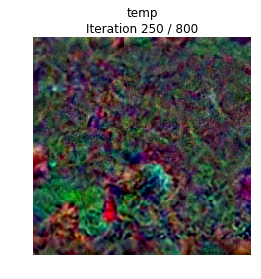

Blur time 0.0562748908997
iteration: 250 287.088586092
iteration: 251 288.153620958
Blur time 0.0673160552979
iteration: 252 289.324572086
iteration: 253 290.425710917
Blur time 0.0485849380493
iteration: 254 291.575700045
iteration: 255 292.64546895
Blur time 0.0794339179993
iteration: 256 293.788677931
iteration: 257 294.894639969
Blur time 0.0652899742126
iteration: 258 296.072592974
iteration: 259 297.172590971
Blur time 0.0475161075592
iteration: 260 298.31791997
iteration: 261 299.38025403
Blur time 0.0626368522644
iteration: 262 300.490461111
iteration: 263 301.590037107
Blur time 0.0809478759766
iteration: 264 302.787359953
iteration: 265 304.029597998
Blur time 0.0845990180969
iteration: 266 305.218997955
iteration: 267 306.339539051
Blur time 0.0840950012207
iteration: 268 307.54260993
iteration: 269 308.712312937
Blur time 0.0854780673981
iteration: 270 309.966350079
iteration: 271 311.099705935
Blur time 0.0721809864044
iteration: 272 312.317574978
iteration: 273 313.459464

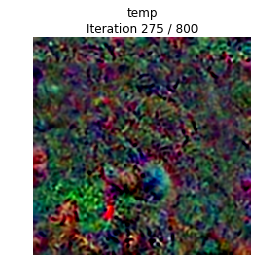

iteration: 275 315.914408922
Blur time 0.0716931819916
iteration: 276 317.137835026
iteration: 277 318.257435083
Blur time 0.0788629055023
iteration: 278 319.454118967
iteration: 279 320.573534966
Blur time 0.087249994278
iteration: 280 321.797861099
iteration: 281 322.945528984
Blur time 0.0849900245667
iteration: 282 324.194549084
iteration: 283 325.333943129
Blur time 0.082661151886
iteration: 284 326.569742918
iteration: 285 327.72834897
Blur time 0.0823321342468
iteration: 286 329.02760911
iteration: 287 330.119153023
Blur time 0.088122844696
iteration: 288 331.377129078
iteration: 289 332.513903141
Blur time 0.0682039260864
iteration: 290 333.722975969
iteration: 291 334.83968401
Blur time 0.0474081039429
iteration: 292 336.023595095
iteration: 293 337.09996295
Blur time 0.0861217975616
iteration: 294 338.338262081
iteration: 295 339.477479935
Blur time 0.0739228725433
iteration: 296 340.695011139
iteration: 297 341.813004971
Blur time 0.0518589019775
iteration: 298 342.995975971

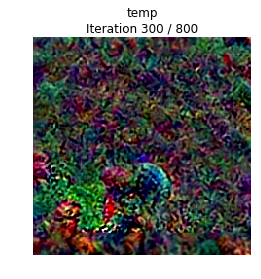

Blur time 0.0547330379486
iteration: 300 345.378258944
iteration: 301 346.482943058
Blur time 0.0866899490356
iteration: 302 347.70977211
iteration: 303 348.83358407
Blur time 0.0855190753937
iteration: 304 350.068684101
iteration: 305 351.194679022
Blur time 0.0868408679962
iteration: 306 352.443882942
iteration: 307 353.561109066
Blur time 0.050873041153
iteration: 308 354.751250029
iteration: 309 355.832662106
Blur time 0.0840721130371
iteration: 310 357.140042067
iteration: 311 358.257699013
Blur time 0.0823562145233
iteration: 312 359.488114119
iteration: 313 360.592518091
Blur time 0.0461180210114
iteration: 314 361.685173988
iteration: 315 362.733705997
Blur time 0.0853660106659
iteration: 316 363.927772045
iteration: 317 365.045932055
Blur time 0.0608110427856
iteration: 318 366.251289129
iteration: 319 367.337265968
Blur time 0.0487298965454
iteration: 320 368.480845928
iteration: 321 369.538100004
Blur time 0.044814825058
iteration: 322 370.621685028
iteration: 323 371.683686

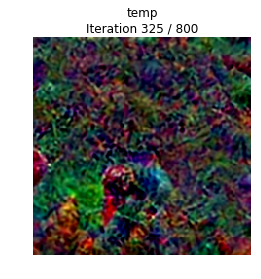

iteration: 325 374.109833956
Blur time 0.0832650661469
iteration: 326 375.25040102
iteration: 327 376.355070114
Blur time 0.0858540534973
iteration: 328 377.540168047
iteration: 329 378.674056053
Blur time 0.0880179405212
iteration: 330 379.920735121
iteration: 331 381.095113993
Blur time 0.0861132144928
iteration: 332 382.311079025
iteration: 333 383.444657087
Blur time 0.0861999988556
iteration: 334 384.665373087
iteration: 335 385.803885937
Blur time 0.0697810649872
iteration: 336 387.029966116
iteration: 337 388.143938065
Blur time 0.0827691555023
iteration: 338 389.383899927
iteration: 339 390.515228987
Blur time 0.0478060245514
iteration: 340 391.704066038
iteration: 341 392.776505947
Blur time 0.07053399086
iteration: 342 393.965615988
iteration: 343 395.085735083
Blur time 0.0675129890442
iteration: 344 396.306756973
iteration: 345 397.405611992
Blur time 0.05499792099
iteration: 346 398.579838037
iteration: 347 399.675187111
Blur time 0.0721559524536
iteration: 348 400.8569300

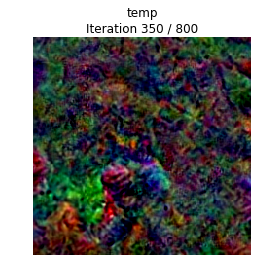

Blur time 0.0474281311035
iteration: 350 403.245104074
iteration: 351 404.312688112
Blur time 0.0681259632111
iteration: 352 405.49317503
iteration: 353 406.605986118
Blur time 0.0478880405426
iteration: 354 407.761321068
iteration: 355 408.829071999
Blur time 0.0465929508209
iteration: 356 409.939284086
iteration: 357 411.00365901
Blur time 0.0647659301758
iteration: 358 412.18800807
iteration: 359 413.301852942
Blur time 0.0455968379974
iteration: 360 414.48960495
iteration: 361 415.547191143
Blur time 0.0476241111755
iteration: 362 416.684302092
iteration: 363 417.75161314
Blur time 0.0861840248108
iteration: 364 418.996990919
iteration: 365 420.12720108
Blur time 0.0703568458557
iteration: 366 421.351172924
iteration: 367 422.425612926
Blur time 0.050106048584
iteration: 368 423.622736931
iteration: 369 424.714874029
Blur time 0.0839509963989
iteration: 370 425.951698065
iteration: 371 427.071613073
Blur time 0.0698368549347
iteration: 372 428.29259491
iteration: 373 429.402553082


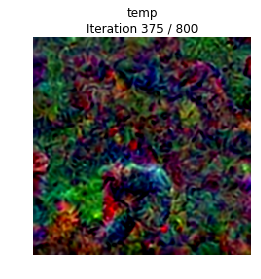

iteration: 375 431.806455135
Blur time 0.0836751461029
iteration: 376 433.037636042
iteration: 377 434.17555809
Blur time 0.0518550872803
iteration: 378 435.374964952
iteration: 379 436.466342926
Blur time 0.0554349422455
iteration: 380 437.646328926
iteration: 381 438.741739035
Blur time 0.0862190723419
iteration: 382 439.955029011
iteration: 383 441.108783007
Blur time 0.0866839885712
iteration: 384 442.35040307
iteration: 385 443.489104033
Blur time 0.0823340415955
iteration: 386 444.687192917
iteration: 387 445.806519985
Blur time 0.0670440196991
iteration: 388 447.013617992
iteration: 389 448.113111019
Blur time 0.088604927063
iteration: 390 449.304950953
iteration: 391 450.444585085
Blur time 0.083881855011
iteration: 392 451.65765214
iteration: 393 452.781759977
Blur time 0.0851001739502
iteration: 394 453.948159933
iteration: 395 455.082844019
Blur time 0.0731461048126
iteration: 396 456.29575491
iteration: 397 457.42220211
Blur time 0.082062959671
iteration: 398 458.653245926


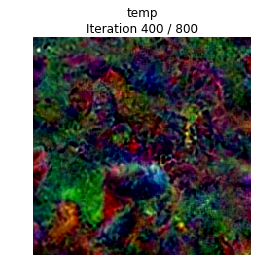

Blur time 0.0770671367645
iteration: 400 461.11552906
iteration: 401 462.203274012
Blur time 0.0878858566284
iteration: 402 463.405682087
iteration: 403 464.541631937
Blur time 0.0474028587341
iteration: 404 465.731291056
iteration: 405 466.798624039
Blur time 0.0569880008698
iteration: 406 467.915061951
iteration: 407 469.020304918
Blur time 0.0473940372467
iteration: 408 470.219924927
iteration: 409 471.291327953
Blur time 0.0757739543915
iteration: 410 472.439069033
iteration: 411 473.551888943
Blur time 0.0650329589844
iteration: 412 474.71867013
iteration: 413 475.824492931
Blur time 0.0473539829254
iteration: 414 477.025821924
iteration: 415 478.092647076
Blur time 0.0865671634674
iteration: 416 479.331092119
iteration: 417 480.463280916
Blur time 0.0701839923859
iteration: 418 481.68362999
iteration: 419 482.763759136
Blur time 0.0877649784088
iteration: 420 484.04894805
iteration: 421 485.204164028
Blur time 0.0604379177094
iteration: 422 486.413021088
iteration: 423 487.522536

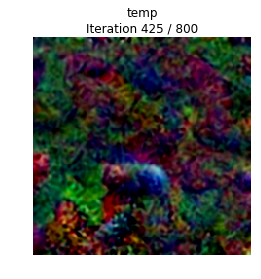

iteration: 425 490.036919117
Blur time 0.070858001709
iteration: 426 491.239824057
iteration: 427 492.354138136
Blur time 0.0838279724121
iteration: 428 493.581179142
iteration: 429 494.71027112
Blur time 0.0864610671997
iteration: 430 495.950809002
iteration: 431 497.07221508
Blur time 0.084841966629
iteration: 432 498.256715059
iteration: 433 499.37321806
Blur time 0.0709829330444
iteration: 434 500.573727131
iteration: 435 501.680536032
Blur time 0.082160949707
iteration: 436 502.918005943
iteration: 437 504.039591074
Blur time 0.0484170913696
iteration: 438 505.196236134
iteration: 439 506.265000105
Blur time 0.0820350646973
iteration: 440 507.475085974
iteration: 441 508.602445126
Blur time 0.0695288181305
iteration: 442 509.824062109
iteration: 443 510.946653128
Blur time 0.0713150501251
iteration: 444 512.159963131
iteration: 445 513.274996996
Blur time 0.08455991745
iteration: 446 514.520400047
iteration: 447 515.648550987
Blur time 0.0694539546967
iteration: 448 516.852468014


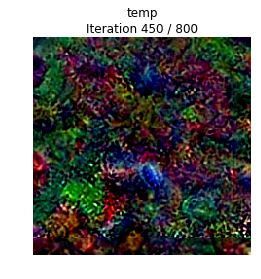

Blur time 0.0673539638519
iteration: 450 519.235497952
iteration: 451 520.348398924
Blur time 0.0481309890747
iteration: 452 521.520646095
iteration: 453 522.592080116
Blur time 0.0836749076843
iteration: 454 523.732015133
iteration: 455 524.839020014
Blur time 0.0474460124969
iteration: 456 526.021527052
iteration: 457 527.082750082
Blur time 0.0671410560608
iteration: 458 528.205122948
iteration: 459 529.317512035
Blur time 0.0575480461121
iteration: 460 530.460217953
iteration: 461 531.569900036
Blur time 0.0647649765015
iteration: 462 532.796221972
iteration: 463 533.902709007
Blur time 0.0783760547638
iteration: 464 535.162007093
iteration: 465 536.276369095
Blur time 0.0744371414185
iteration: 466 537.477373123
iteration: 467 538.596611023
Blur time 0.0858819484711
iteration: 468 539.840616941
iteration: 469 540.970734119
Blur time 0.0726130008698
iteration: 470 542.187351942
iteration: 471 543.307969093
Blur time 0.0474450588226
iteration: 472 544.486024141
iteration: 473 545.55

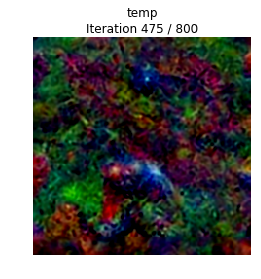

iteration: 475 548.034034014
Blur time 0.0844399929047
iteration: 476 549.278621912
iteration: 477 550.402785063
Blur time 0.0787348747253
iteration: 478 551.554120064
iteration: 479 552.668246984
Blur time 0.0726261138916
iteration: 480 553.891065121
iteration: 481 554.996515989
Blur time 0.0771570205688
iteration: 482 556.141572952
iteration: 483 557.258758068
Blur time 0.0848867893219
iteration: 484 558.493324041
iteration: 485 559.607489109
Blur time 0.0836188793182
iteration: 486 560.81380105
iteration: 487 561.939206123
Blur time 0.0805730819702
iteration: 488 563.148952961
iteration: 489 564.27174902
Blur time 0.0846371650696
iteration: 490 565.515126944
iteration: 491 566.649281979
Blur time 0.0875618457794
iteration: 492 567.892352104
iteration: 493 569.020260096
Blur time 0.0696198940277
iteration: 494 570.221033096
iteration: 495 571.337105989
Blur time 0.0766468048096
iteration: 496 572.571411133
iteration: 497 573.700449944
Blur time 0.0726380348206
iteration: 498 574.9270

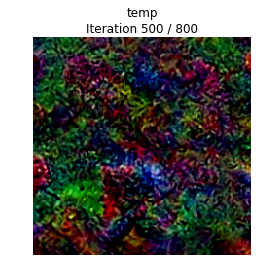

Blur time 0.0740418434143
iteration: 500 577.40810895
iteration: 501 578.512612104
Blur time 0.0876441001892
iteration: 502 579.756036997
iteration: 503 580.883017063
Blur time 0.0851099491119
iteration: 504 582.094156981
iteration: 505 583.237810135
Blur time 0.078919172287
iteration: 506 584.483792067
iteration: 507 585.615539074
Blur time 0.0847749710083
iteration: 508 586.84593606
iteration: 509 587.978662968
Blur time 0.0703461170197
iteration: 510 589.207629919
iteration: 511 590.322124004
Blur time 0.0858249664307
iteration: 512 591.545639038
iteration: 513 592.671185017
Blur time 0.071417093277
iteration: 514 593.881776094
iteration: 515 594.985646009
Blur time 0.0656759738922
iteration: 516 596.149019957
iteration: 517 597.256570101
Blur time 0.046737909317
iteration: 518 598.362103939
iteration: 519 599.421282053
Blur time 0.0588240623474
iteration: 520 600.543385983
iteration: 521 601.607468128
Blur time 0.0863471031189
iteration: 522 602.826296091
iteration: 523 603.9510190

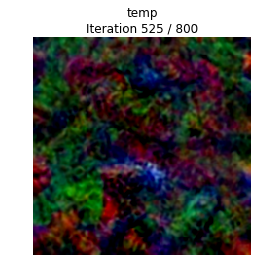

iteration: 525 606.419583082
Blur time 0.0858988761902
iteration: 526 607.593395948
iteration: 527 608.731827021
Blur time 0.0700039863586
iteration: 528 609.948069096
iteration: 529 611.061892033
Blur time 0.047345161438
iteration: 530 612.215060949
iteration: 531 613.276933908
Blur time 0.0454459190369
iteration: 532 614.383322954
iteration: 533 615.435858011
Blur time 0.0826649665833
iteration: 534 616.587760925
iteration: 535 617.714522123
Blur time 0.083899974823
iteration: 536 618.883383989
iteration: 537 620.005888939
Blur time 0.085785150528
iteration: 538 621.226227999
iteration: 539 622.350528955
Blur time 0.0866549015045
iteration: 540 623.591988087
iteration: 541 624.759202003
Blur time 0.0766868591309
iteration: 542 625.917204142
iteration: 543 627.071072102
Blur time 0.0875661373138
iteration: 544 628.33211112
iteration: 545 629.466711044
Blur time 0.0824511051178
iteration: 546 630.796105146
iteration: 547 631.910228014
Blur time 0.0663750171661
iteration: 548 633.039307

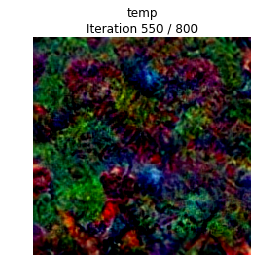

Blur time 0.0876431465149
iteration: 550 635.518306971
iteration: 551 636.643187046
Blur time 0.0680510997772
iteration: 552 637.862110138
iteration: 553 638.975053072
Blur time 0.0872020721436
iteration: 554 640.196748018
iteration: 555 641.317706108
Blur time 0.0868680477142
iteration: 556 642.505969048
iteration: 557 643.631526947
Blur time 0.0816190242767
iteration: 558 644.85552001
iteration: 559 645.978483915
Blur time 0.0691349506378
iteration: 560 647.195641041
iteration: 561 648.311454058
Blur time 0.0843029022217
iteration: 562 649.482304096
iteration: 563 650.592329979
Blur time 0.0844759941101
iteration: 564 651.839046001
iteration: 565 652.974225998
Blur time 0.0855941772461
iteration: 566 654.264198065
iteration: 567 655.368677139
Blur time 0.0618591308594
iteration: 568 656.521738052
iteration: 569 657.613768101
Blur time 0.0779550075531
iteration: 570 658.829613924
iteration: 571 659.942939043
Blur time 0.0689308643341
iteration: 572 661.137773991
iteration: 573 662.264

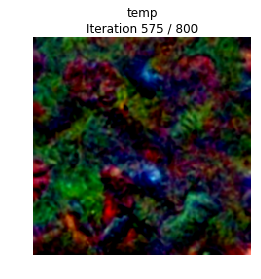

iteration: 575 664.808978081
Blur time 0.0711400508881
iteration: 576 666.028665066
iteration: 577 667.145539045
Blur time 0.0597159862518
iteration: 578 668.328423023
iteration: 579 669.428937912
Blur time 0.0865108966827
iteration: 580 670.647375107
iteration: 581 671.783246994
Blur time 0.0849678516388
iteration: 582 673.032213926
iteration: 583 674.167160034
Blur time 0.0846621990204
iteration: 584 675.384593964
iteration: 585 676.506999969
Blur time 0.0608229637146
iteration: 586 677.695585966
iteration: 587 678.82426405
Blur time 0.0822141170502
iteration: 588 680.071411133
iteration: 589 681.210849047
Blur time 0.0584042072296
iteration: 590 682.416249037
iteration: 591 683.522449017
Blur time 0.0474119186401
iteration: 592 684.718258142
iteration: 593 685.799897909
Blur time 0.0840182304382
iteration: 594 687.043892145
iteration: 595 688.168842077
Blur time 0.0869221687317
iteration: 596 689.426531076
iteration: 597 690.568682909
Blur time 0.0875329971313
iteration: 598 691.834

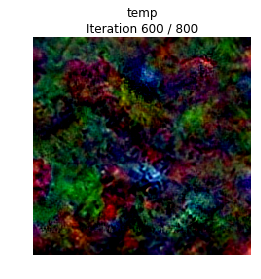

Blur time 0.0848028659821
iteration: 600 694.332673073
iteration: 601 695.462647915
Blur time 0.0706069469452
iteration: 602 696.66783905
iteration: 603 697.780151129
Blur time 0.0876851081848
iteration: 604 699.033973932
iteration: 605 700.22100997
Blur time 0.0871930122375
iteration: 606 701.457499981
iteration: 607 702.597324133
Blur time 0.0860829353333
iteration: 608 703.856260061
iteration: 609 705.001488924
Blur time 0.0712928771973
iteration: 610 706.25267005
iteration: 611 707.385565996
Blur time 0.0835030078888
iteration: 612 708.637920141
iteration: 613 709.758217096
Blur time 0.0664281845093
iteration: 614 710.890308142
iteration: 615 711.984753132
Blur time 0.0475678443909
iteration: 616 713.099110126
iteration: 617 714.173468113
Blur time 0.0694301128387
iteration: 618 715.410941124
iteration: 619 716.539149046
Blur time 0.0844659805298
iteration: 620 717.752380133
iteration: 621 718.889341116
Blur time 0.0495629310608
iteration: 622 720.02282095
iteration: 623 721.099407

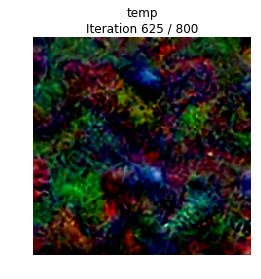

iteration: 625 723.50355792
Blur time 0.088308095932
iteration: 626 724.758404016
iteration: 627 725.899862051
Blur time 0.0582630634308
iteration: 628 727.131204128
iteration: 629 728.248975039
Blur time 0.0679941177368
iteration: 630 729.47793293
iteration: 631 730.596844912
Blur time 0.0870599746704
iteration: 632 731.828869104
iteration: 633 732.954579115
Blur time 0.0816810131073
iteration: 634 734.138245106
iteration: 635 735.249372005
Blur time 0.0474650859833
iteration: 636 736.462949991
iteration: 637 737.546903133
Blur time 0.0476670265198
iteration: 638 738.719974995
iteration: 639 739.793844938
Blur time 0.0544118881226
iteration: 640 741.007287979
iteration: 641 742.10957098
Blur time 0.0710289478302
iteration: 642 743.352813959
iteration: 643 744.472125053
Blur time 0.0473301410675
iteration: 644 745.628168106
iteration: 645 746.701779127
Blur time 0.0704369544983
iteration: 646 747.901550055
iteration: 647 749.022723913
Blur time 0.0475599765778
iteration: 648 750.233041

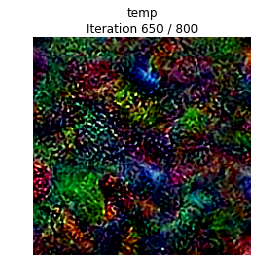

Blur time 0.0858788490295
iteration: 650 752.683300972
iteration: 651 753.810046911
Blur time 0.0848591327667
iteration: 652 755.053666115
iteration: 653 756.17871213
Blur time 0.0514581203461
iteration: 654 757.325016022
iteration: 655 758.393465042
Blur time 0.0553860664368
iteration: 656 759.520039082
iteration: 657 760.620580912
Blur time 0.0839610099792
iteration: 658 761.813730001
iteration: 659 762.946028948
Blur time 0.0842349529266
iteration: 660 764.186015129
iteration: 661 765.322627068
Blur time 0.0691139698029
iteration: 662 766.54729104
iteration: 663 767.668350935
Blur time 0.0848259925842
iteration: 664 768.906337023
iteration: 665 770.023551941
Blur time 0.0733668804169
iteration: 666 771.242238045
iteration: 667 772.356544018
Blur time 0.071033000946
iteration: 668 773.591118097
iteration: 669 774.72924304
Blur time 0.0476369857788
iteration: 670 775.929219007
iteration: 671 777.002659082
Blur time 0.0836479663849
iteration: 672 778.195487022
iteration: 673 779.331939

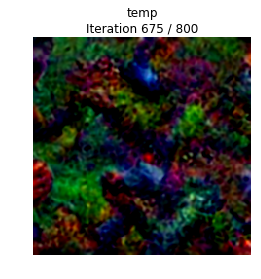

iteration: 675 781.841309071
Blur time 0.0724408626556
iteration: 676 783.107142925
iteration: 677 784.231920958
Blur time 0.084734916687
iteration: 678 785.487829924
iteration: 679 786.615864992
Blur time 0.0885188579559
iteration: 680 787.917629957
iteration: 681 789.097891092
Blur time 0.0891540050507
iteration: 682 790.392843008
iteration: 683 791.537344933
Blur time 0.0684278011322
iteration: 684 792.726748943
iteration: 685 793.837816954
Blur time 0.0794441699982
iteration: 686 794.999556065
iteration: 687 796.124644995
Blur time 0.0589950084686
iteration: 688 797.254275084
iteration: 689 798.356868982
Blur time 0.0540759563446
iteration: 690 799.489140034
iteration: 691 800.587553978
Blur time 0.0789539813995
iteration: 692 801.749429941
iteration: 693 802.898077965
Blur time 0.0517218112946
iteration: 694 804.119930029
iteration: 695 805.226707935
Blur time 0.0711250305176
iteration: 696 806.414803982
iteration: 697 807.569895029
Blur time 0.0715730190277
iteration: 698 808.804

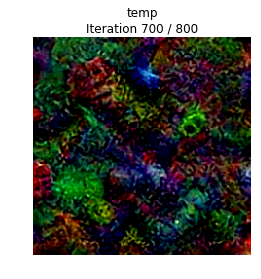

Blur time 0.0820100307465
iteration: 700 811.323246956
iteration: 701 812.47339797
Blur time 0.0476629734039
iteration: 702 813.681858063
iteration: 703 814.783046007
Blur time 0.0672891139984
iteration: 704 816.017437935
iteration: 705 817.133265018
Blur time 0.0840909481049
iteration: 706 818.385435104
iteration: 707 819.507969141
Blur time 0.0545210838318
iteration: 708 820.700355053
iteration: 709 821.810241938
Blur time 0.0584180355072
iteration: 710 823.033572912
iteration: 711 824.136552095
Blur time 0.044704914093
iteration: 712 825.251416922
iteration: 713 826.321425915
Blur time 0.0721960067749
iteration: 714 827.525197029
iteration: 715 828.659955025
Blur time 0.0811388492584
iteration: 716 829.953987122
iteration: 717 831.09841013
Blur time 0.0836079120636
iteration: 718 832.292184114
iteration: 719 833.422869921
Blur time 0.0866799354553
iteration: 720 834.67200613
iteration: 721 835.796113968
Blur time 0.0868020057678
iteration: 722 837.049582958
iteration: 723 838.176767

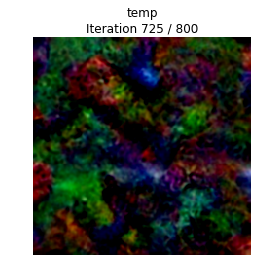

iteration: 725 840.584685087
Blur time 0.0862739086151
iteration: 726 841.746397018
iteration: 727 842.86939311
Blur time 0.0860950946808
iteration: 728 844.047810078
iteration: 729 845.190177917
Blur time 0.0881340503693
iteration: 730 846.447061062
iteration: 731 847.58523798
Blur time 0.0880990028381
iteration: 732 848.8427701
iteration: 733 849.982006073
Blur time 0.0875999927521
iteration: 734 851.222723961
iteration: 735 852.361985922
Blur time 0.0830140113831
iteration: 736 853.607177973
iteration: 737 854.736148119
Blur time 0.0502190589905
iteration: 738 855.938298941
iteration: 739 857.034929991
Blur time 0.0727360248566
iteration: 740 858.191978931
iteration: 741 859.318726063
Blur time 0.0497078895569
iteration: 742 860.527921915
iteration: 743 861.61887908
Blur time 0.0616629123688
iteration: 744 862.754295111
iteration: 745 863.862895012
Blur time 0.0632879734039
iteration: 746 865.078867912
iteration: 747 866.191309929
Blur time 0.06547498703
iteration: 748 867.334375143

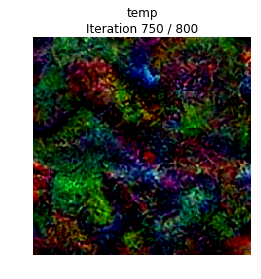

Blur time 0.0878219604492
iteration: 750 869.774673939
iteration: 751 870.90268898
Blur time 0.0562381744385
iteration: 752 872.083997965
iteration: 753 873.178276062
Blur time 0.0680599212646
iteration: 754 874.324553013
iteration: 755 875.436584949
Blur time 0.0862159729004
iteration: 756 876.596406937
iteration: 757 877.718914032
Blur time 0.0452318191528
iteration: 758 878.83991003
iteration: 759 879.88824296
Blur time 0.0864109992981
iteration: 760 881.048689127
iteration: 761 882.161188126
Blur time 0.0877320766449
iteration: 762 883.421672106
iteration: 763 884.542418003
Blur time 0.0739719867706
iteration: 764 885.726809978
iteration: 765 886.852411032
Blur time 0.0656139850616
iteration: 766 888.05567193
iteration: 767 889.180072069
Blur time 0.0451300144196
iteration: 768 890.31122613
iteration: 769 891.389284134
Blur time 0.0767419338226
iteration: 770 892.557956934
iteration: 771 893.702393055
Blur time 0.0496490001678
iteration: 772 894.925966024
iteration: 773 896.0318889

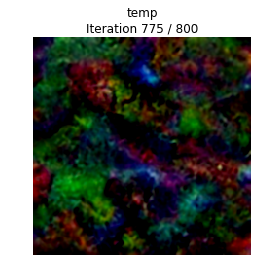

iteration: 775 898.496840954
Blur time 0.0735509395599
iteration: 776 899.69610405
iteration: 777 900.839906931
Blur time 0.0870640277863
iteration: 778 902.083070993
iteration: 779 903.248543978
Blur time 0.0628349781036
iteration: 780 904.52944994
iteration: 781 905.660469055
Blur time 0.0841729640961
iteration: 782 906.897264004
iteration: 783 908.0642941
Blur time 0.0500450134277
iteration: 784 909.271364927
iteration: 785 910.41736412
Blur time 0.0450730323792
iteration: 786 911.597106934
iteration: 787 912.675303936
Blur time 0.0475618839264
iteration: 788 913.882014036
iteration: 789 914.948480129
Blur time 0.0469439029694
iteration: 790 916.060903072
iteration: 791 917.147217989
Blur time 0.0475931167603
iteration: 792 918.344332933
iteration: 793 919.41229105
Blur time 0.0466771125793
iteration: 794 920.529448032
iteration: 795 921.60812211
Blur time 0.0795869827271
iteration: 796 922.860917091
iteration: 797 923.977739096
Blur time 0.0459899902344
iteration: 798 925.098709106

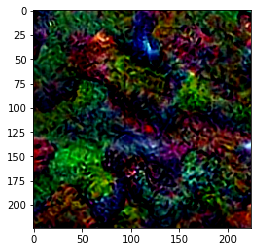

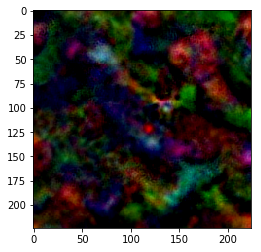

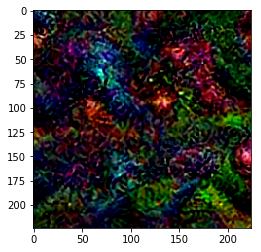

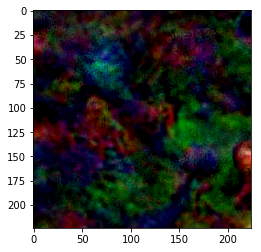

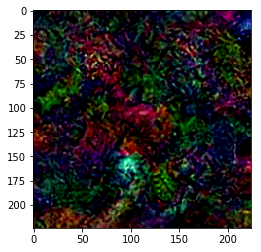

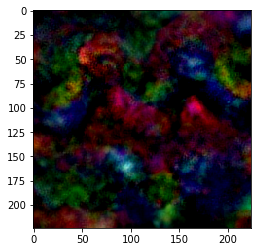

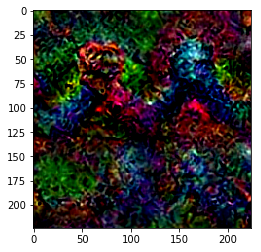

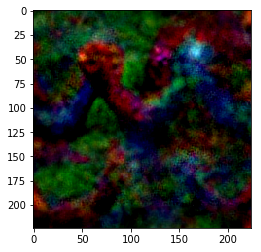

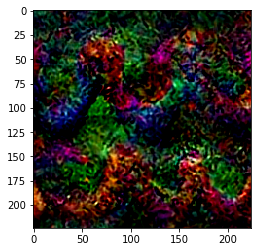

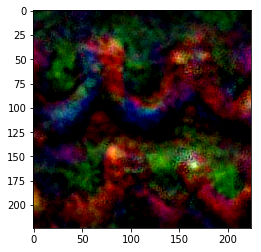

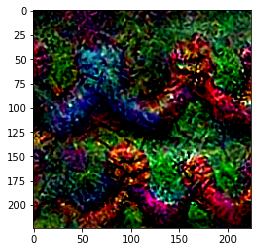

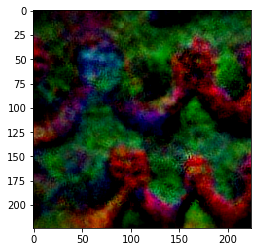

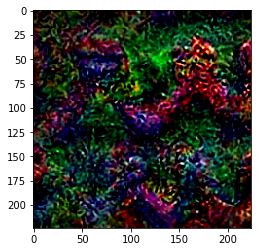

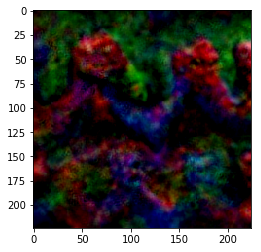

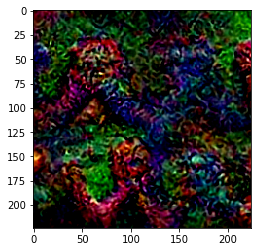

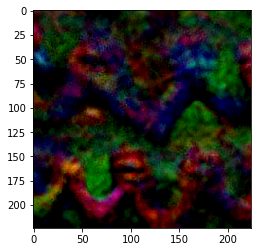

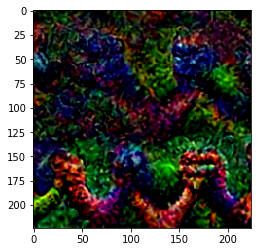

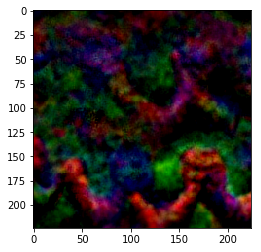

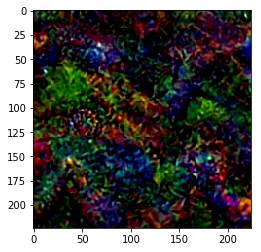

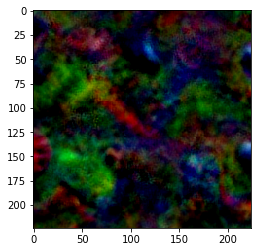

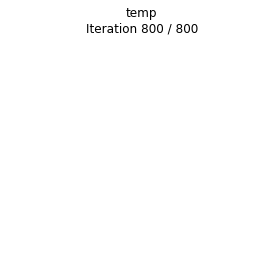

In [25]:
import imageio
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(model_logits)
print(rgb_input)
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        create_class_visualization(sess, 6, model_logits, rgb_input, 20, num_iterations=1000, learning_rate=1.5, blur_every=3, max_jitter=32)